In [33]:
import numpy as np
import pandas as pd
import pickle
from sklearn.cluster import KMeans

with open('new.pkl', 'rb') as f:
    cluster_labels = pickle.load(f)
    
dataset = pd.read_csv('final_1102022.csv')
dataset['cluster_id'] = cluster_labels


dataset = dataset.loc[dataset['GM%'] >= -10]
dataset = dataset.loc[dataset['GM%'] <= 1]

In [34]:
dataset.shape

(1100264, 28)

In [35]:
## DROP WHERE # OF DATAPOINTS < 5 (cannot cluster at all)
cluster_sizes = dataset.groupby(['cluster_id']).cluster_id.size()
bad_clusters = cluster_sizes.where(lambda x: x < 5).dropna()
print("dropping clusters: ", bad_clusters.index)

dataset = dataset.loc[~dataset['cluster_id'].isin(bad_clusters.index)]

clusters = dataset.cluster_id.unique()
print("has clusters: ", clusters, " len = ", len(clusters))

dropping clusters:  Int64Index([3, 48, 51], dtype='int64', name='cluster_id')
has clusters:  [37 40 53 63 78 57 23 67 77 69 35 66 20 26 70 52 62 72 21 82 13 87 27 80
 25 61 81 32 46 68 74 17 29 38 28 33 16 45 42 10 19 76  2 39 65 22 41 79
 86 34 84 49 71 59  0 58 43 24 83 18  1 15 73 54 50 44 64  6 30 31 56 47
  7 55 75 12 11 36  9 60  8  5 14]  len =  83


In [36]:
#kmeans = [KMeans(n_clusters=5).fit(np.array(dataset.loc[dataset.cluster_id == cid]['GM%'].array).reshape(-1, 1)) for cid in cluster_labels]

kmeans_objs = [] # list of tuples - cluster id, corresponding KMeans obj
for cid in clusters:
    data = np.array(dataset.loc[dataset.cluster_id == cid]['GM%'].array).reshape(-1, 1)
    #print("training KMeans on {} datapoints for cluster {}".format(data.shape[0], cid))
    kmeans = KMeans(n_clusters=5).fit(data)
    kmeans_objs.append((cid, kmeans))

In [37]:
# dataset diff between max and min GM%
print("in entire dataset, gm% range: ", dataset['GM%'].max() - dataset['GM%'].min())

dgb = dataset.groupby(['cluster_id'])
gm_ranges = (dgb['GM%'].max() - dgb['GM%'].min())
print(gm_ranges)



in entire dataset, gm% range:  11.0
cluster_id
0     10.572816
1     10.967439
2     10.935484
5      2.352332
6     10.333333
        ...    
82     9.642857
83    10.671053
84    10.894737
86    10.720000
87    10.570928
Name: GM%, Length: 83, dtype: float64


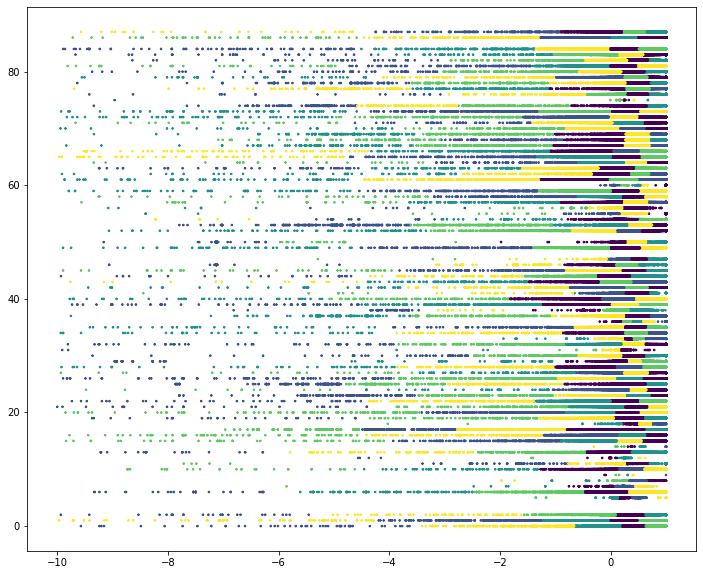

In [38]:
# assign price grades for each cluster centroid/labels
import matplotlib.pyplot as plt
for cid, kmeans in kmeans_objs:
    dataset.loc[dataset.cluster_id == cid, 'price_grade_cluster_ind'] = kmeans.labels_

dataset['price_grade_cluster_ind'] = dataset['price_grade_cluster_ind'].astype(int)


fig = plt.gcf()
fig.set_size_inches(12, 10)

i = 0
for cid in clusters:
    data = dataset.loc[dataset.cluster_id == cid]
    
    plt.scatter(data['GM%'], [cid]*data.shape[0], marker='x', s=3,c=data['price_grade_cluster_ind'])
#fig.savefig('test2png.png', dpi=200)


In [32]:
clusters_df = pd.DataFrame(clusters, columns=['cluster_id'])
clusters_df.set_index('cluster_id')

for cid, kmeans in kmeans_objs:
    label_center = sorted(zip(range(5), kmeans.cluster_centers_), key=lambda el: el[1], reverse=True)
    clusters_df.loc[clusters_df.cluster_id == cid, 'a_label'] = label_center[0][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'b_label'] = label_center[1][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'c_label'] = label_center[2][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'd_label'] = label_center[3][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'f_label'] = label_center[4][0]
    
clusters_df.astype({'a_label': int, 'b_label': int, 'c_label': int, 'd_label': int, 'f_label': int})

0          4
1          2
2          1
3          1
4          1
          ..
1102017    0
1102018    2
1102019    0
1102020    0
1102021    0
Name: price_grade_cluster_ind, Length: 1100260, dtype: int64

In [50]:
#assign 'price_grade' column to dataset

for cid in clusters:
    a_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['a_label'])
    b_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['b_label'])
    c_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['c_label'])
    d_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['d_label'])
    f_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['f_label'])

    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == a_label_for_cluster), 'price_grade'] = 'A'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == b_label_for_cluster), 'price_grade'] = 'B'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == c_label_for_cluster), 'price_grade'] = 'C'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == d_label_for_cluster), 'price_grade'] = 'D'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == f_label_for_cluster), 'price_grade'] = 'F'

In [55]:
dataset.groupby(['cluster_id', 'price_grade']).size()

cluster_id  price_grade
0           A              7721
            B               373
            C              4608
            D                48
            F              1374
                           ... 
87          A              5774
            B               236
            C              8703
            D                35
            F              1735
Length: 415, dtype: int64